## Setup

In [64]:
%pip install statsmodels pandas scipy matplotlib numpy seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import statsmodels.tsa as tsa
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


## Data Preprocessing

In [66]:
daily_sales = pd.read_csv('salesdaily.csv')

In [67]:
daily_sales.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [68]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datum         2106 non-null   object 
 1   M01AB         2106 non-null   float64
 2   M01AE         2106 non-null   float64
 3   N02BA         2106 non-null   float64
 4   N02BE         2106 non-null   float64
 5   N05B          2106 non-null   float64
 6   N05C          2106 non-null   float64
 7   R03           2106 non-null   float64
 8   R06           2106 non-null   float64
 9   Year          2106 non-null   int64  
 10  Month         2106 non-null   int64  
 11  Hour          2106 non-null   int64  
 12  Weekday Name  2106 non-null   object 
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


In [69]:
# transform datum column into datetime using parser
daily_sales['datum'] = pd.to_datetime(daily_sales['datum'], format='%m/%d/%Y')

In [70]:
# drop columns Year	Month	Hour	Weekday Name
daily_sales.drop(['Year', 'Month', 'Hour', 'Weekday Name'], axis=1, inplace=True)

In [71]:
# rename datum column as date
daily_sales.rename(columns={'datum': 'date'}, inplace=True)

In [72]:
daily_sales.set_index('date', inplace=True)

In [73]:
daily_sales.info()
daily_sales.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-02 to 2019-10-08
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M01AB   2106 non-null   float64
 1   M01AE   2106 non-null   float64
 2   N02BA   2106 non-null   float64
 3   N02BE   2106 non-null   float64
 4   N05B    2106 non-null   float64
 5   N05C    2106 non-null   float64
 6   R03     2106 non-null   float64
 7   R06     2106 non-null   float64
dtypes: float64(8)
memory usage: 148.1 KB


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
date,,,,,,,,
2014-01-02,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0
2014-01-03,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0
2014-01-04,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0
2014-01-05,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0
2014-01-06,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0


In [74]:
# create new column "Total" with the sum of all values in a row
daily_sales['Total'] = daily_sales.sum(axis=1)

Text(0.5, 0, 'Date')

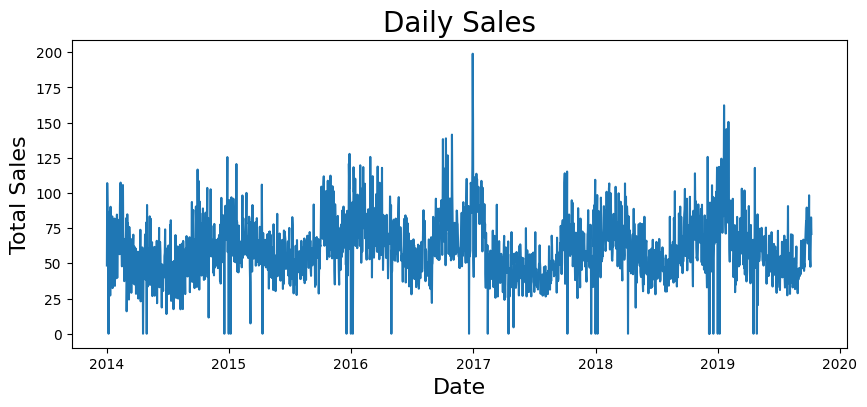

In [75]:
# plot the time series
plt.figure(figsize=(10,4))
plt.plot(daily_sales.index, daily_sales['Total'])
plt.title('Daily Sales', fontsize=20)
plt.ylabel('Total Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)

In [76]:
# create new dataframe with the cumulative values of each column grouped by month
weekly_sales = daily_sales.resample('W').sum()
weekly_sales.info()
weekly_sales.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 302 entries, 2014-01-05 to 2019-10-13
Freq: W-SUN
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M01AB   302 non-null    float64
 1   M01AE   302 non-null    float64
 2   N02BA   302 non-null    float64
 3   N02BE   302 non-null    float64
 4   N05B    302 non-null    float64
 5   N05C    302 non-null    float64
 6   R03     302 non-null    float64
 7   R06     302 non-null    float64
 8   Total   302 non-null    float64
dtypes: float64(9)
memory usage: 23.6 KB


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Total
date,,,,,,,,,
2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0,312.92
2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2,391.81
2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0,450.31
2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0,398.47
2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0,371.95


In [77]:
# drop last row in weekly_sales
weekly_sales = weekly_sales[:-1]

In [78]:
# add columns with the week number and the year from datetimeIndex index
weekly_sales['Week'] = weekly_sales.index.to_series().dt.isocalendar().week
weekly_sales['Year'] = weekly_sales.index.to_series().dt.isocalendar().year

In [79]:
weekly_sales.head()


,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Total,Week,Year
date,,,,,,,,,,,
2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0,312.92,1,2014
2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2,391.81,2,2014
2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0,450.31,3,2014
2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0,398.47,4,2014
2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0,371.95,5,2014


Text(0, 0.5, 'Sales')

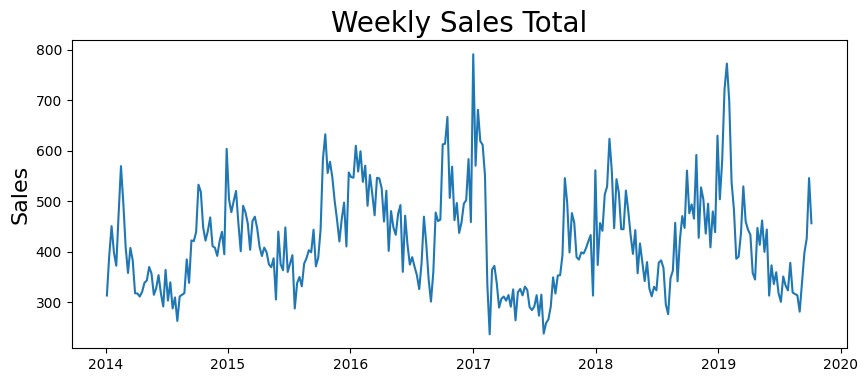

In [80]:
plt.figure(figsize=(10,4))
plt.plot(weekly_sales.index, weekly_sales['Total'])
plt.title('Weekly Sales Total', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [81]:
# store the Weekly sales in a csv file
weekly_sales.to_csv('weekly_sales.csv')

Text(0, 0.5, 'Sales')

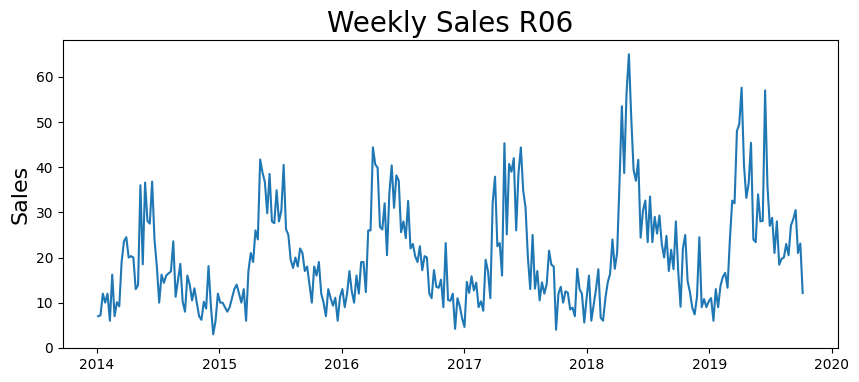

In [82]:
plt.figure(figsize=(10,4))
plt.plot(weekly_sales.index, weekly_sales['R06'])
plt.title('Weekly Sales R06', fontsize=20)
plt.ylabel('Sales', fontsize=16)

<Axes: xlabel='Week', ylabel='Total'>

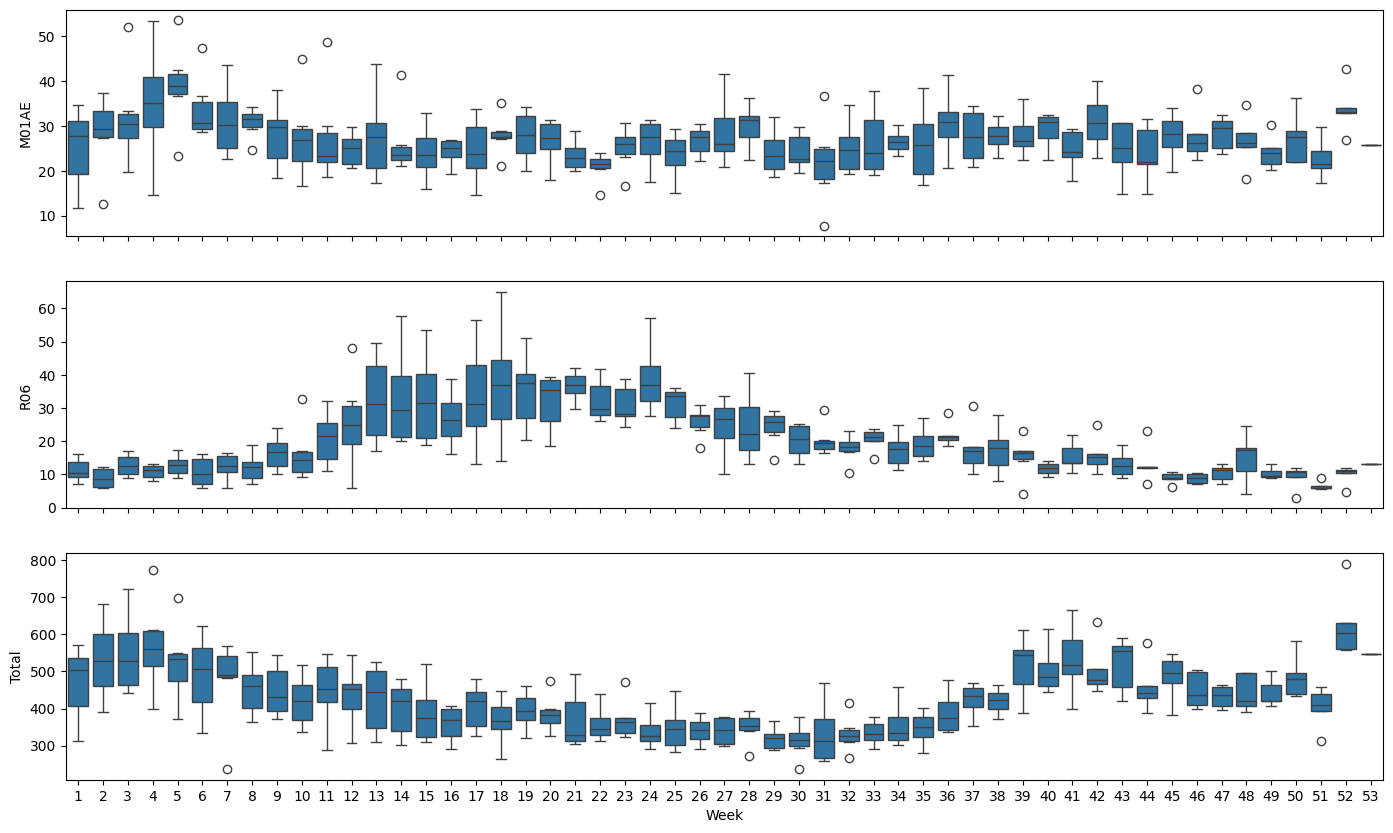

In [83]:

fig, axes = plt.subplots(3, 1, figsize=(17, 10), sharex=True)

sns.boxplot(data=weekly_sales, x='Week', y='M01AE', ax=axes[0])
sns.boxplot(data=weekly_sales, x='Week', y='R06', ax=axes[1])
sns.boxplot(data=weekly_sales, x='Week', y='Total', ax=axes[2])

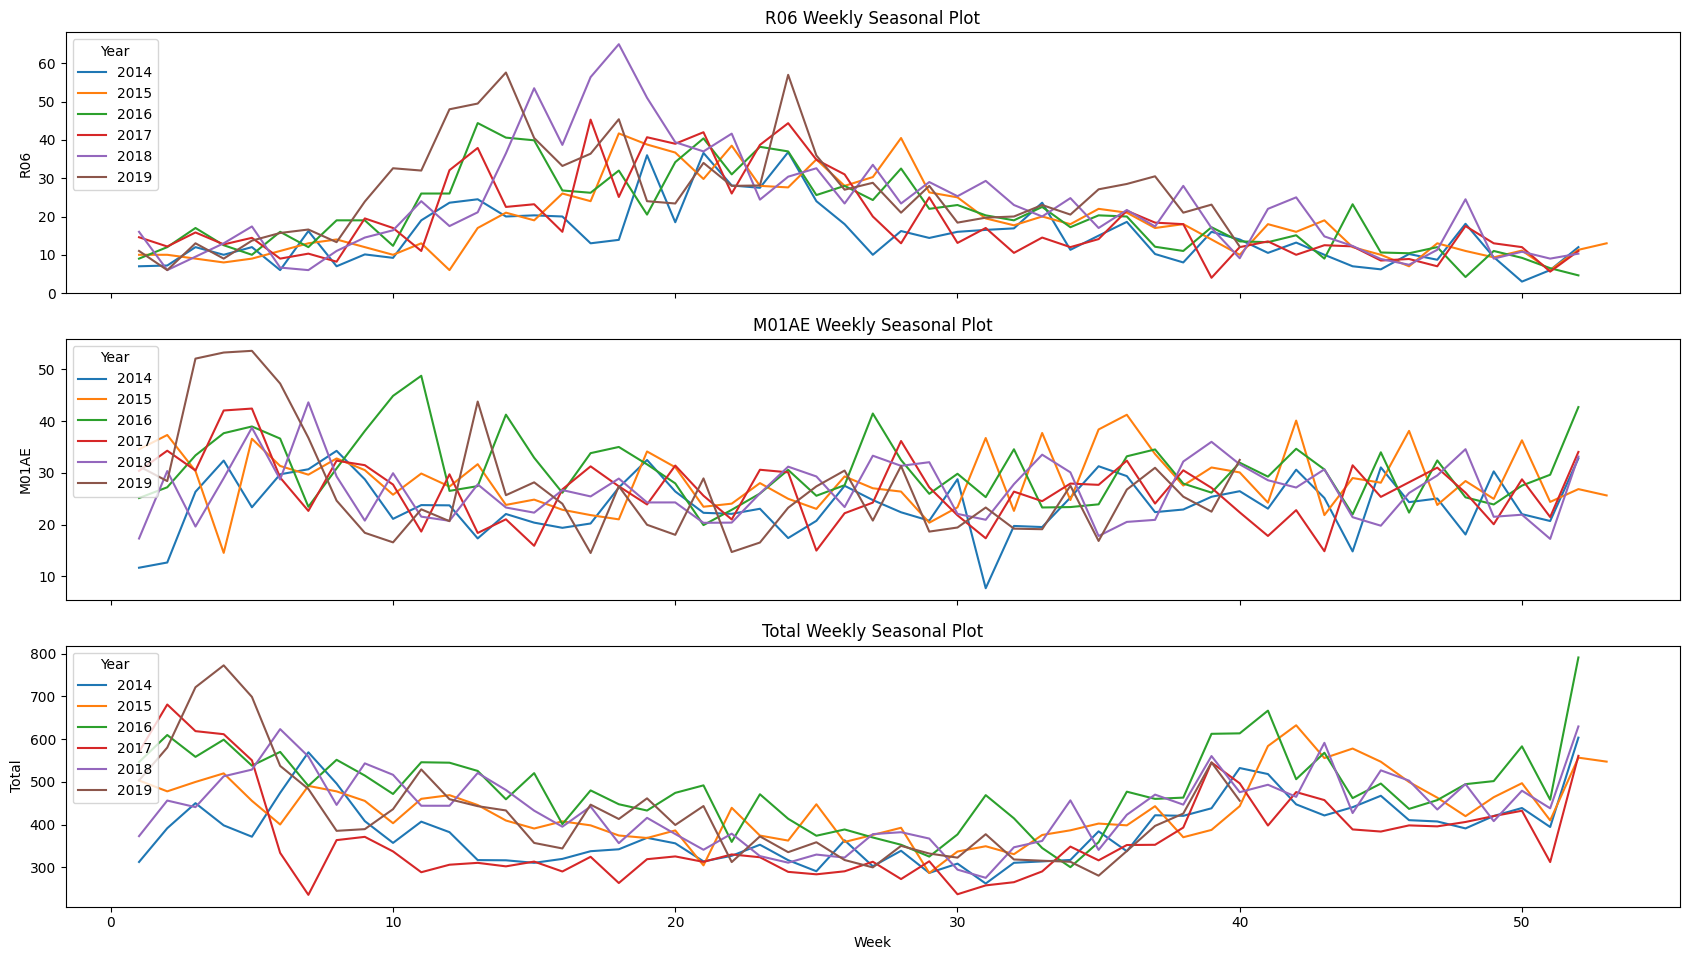

In [84]:
fig, axes = plt.subplots(3, 1, figsize=(17, 10), sharex=True)

# Plotting each subplot
sns.lineplot(data=weekly_sales, x="Week", y="R06", hue="Year", palette="tab10", ax=axes[0])
axes[0].set_title("R06 Weekly Seasonal Plot")
axes[0].legend(title="Year", loc='upper left')

sns.lineplot(data=weekly_sales, x="Week", y="M01AE", hue="Year", palette="tab10", ax=axes[1])
axes[1].set_title("M01AE Weekly Seasonal Plot")
axes[1].legend(title="Year", loc='upper left')

sns.lineplot(data=weekly_sales, x="Week", y="Total", hue="Year", palette="tab10", ax=axes[2])
axes[2].set_title("Total Weekly Seasonal Plot")
axes[2].legend(title="Year", loc='upper left')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the suptitle

# Display the plot
plt.show()

Text(0, 0.5, 'Sales')

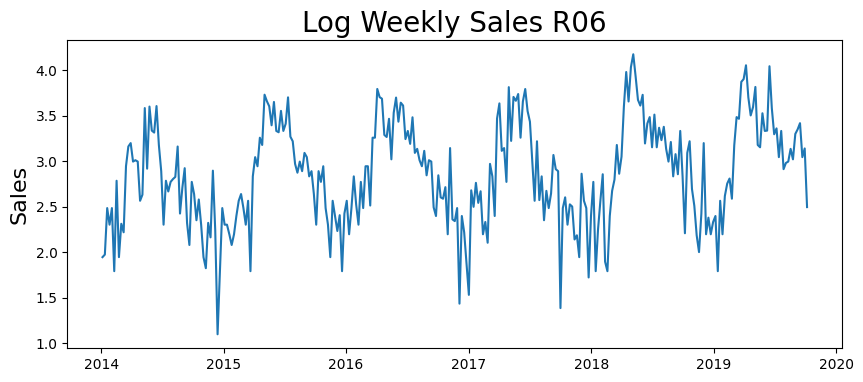

In [85]:
# log transformed weekly sales
R06_log = np.log(weekly_sales['R06'])

plt.figure(figsize=(10,4))
plt.plot(weekly_sales.index, R06_log)
plt.title('Log Weekly Sales R06', fontsize=20)
plt.ylabel('Sales', fontsize=16)

Text(0, 0.5, 'Sales')

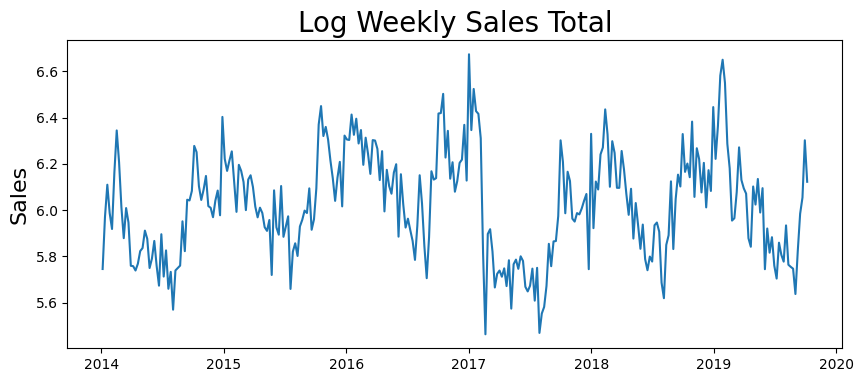

In [86]:
total_log = np.log(weekly_sales['Total'])

plt.figure(figsize=(10,4))
plt.plot(weekly_sales.index, total_log)
plt.title('Log Weekly Sales Total', fontsize=20)
plt.ylabel('Sales', fontsize=16)

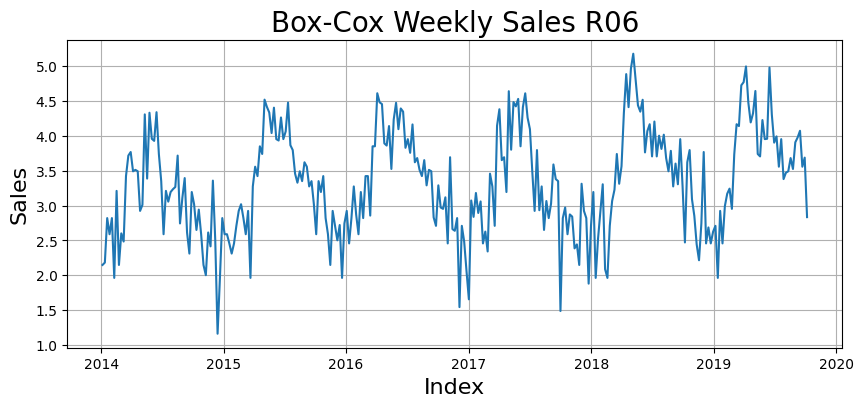

In [87]:
# boxcox transformation of the weekly sales

from scipy.stats import boxcox

# Apply Box-Cox transformation
R06_boxcox, lambda_R06 = boxcox(weekly_sales['R06'])
total_boxcox, lambda_total = boxcox(weekly_sales['Total'])

plt.figure(figsize=(10, 4))
plt.plot(weekly_sales.index, R06_boxcox)
plt.title('Box-Cox Weekly Sales R06', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Index', fontsize=16)
plt.grid(True)
plt.show()

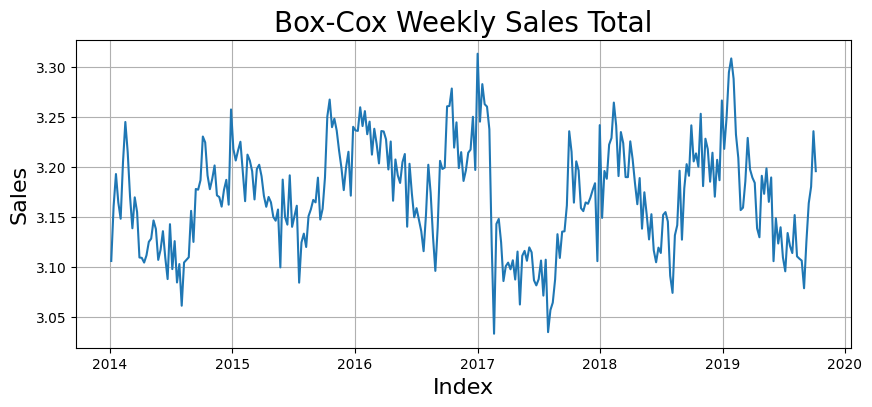

In [88]:
plt.figure(figsize=(10, 4))
plt.plot(weekly_sales.index, total_boxcox)
plt.title('Box-Cox Weekly Sales Total', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Index', fontsize=16)
plt.grid(True)
plt.show()

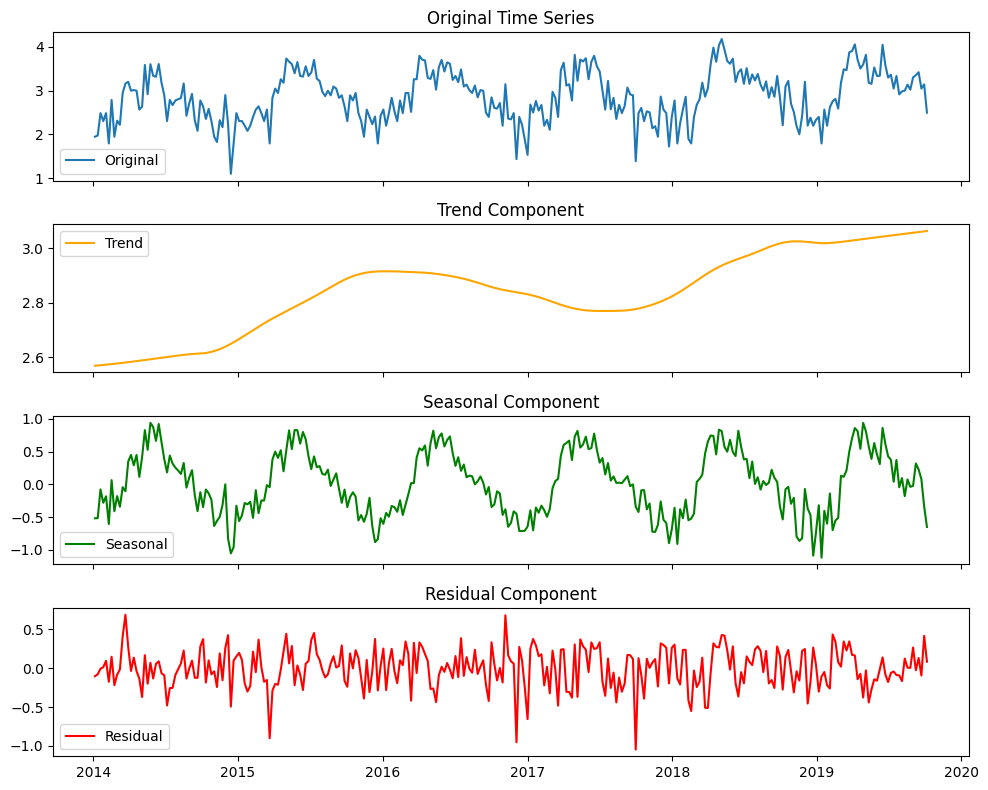

In [89]:
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL

stl = STL(R06_log, seasonal=53)  # Adjust the seasonal parameter based on the frequency of your data
stl_result = stl.fit()

# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original time series
axes[0].plot(R06_log, label='Original')
axes[0].set_title("Original Time Series")
axes[0].legend()

# Trend component
axes[1].plot(stl_result.trend, label='Trend', color='orange')
axes[1].set_title("Trend Component")
axes[1].legend()

# Seasonal component
axes[2].plot(stl_result.seasonal, label='Seasonal', color='green')
axes[2].set_title("Seasonal Component")
axes[2].legend()

# Residual component
axes[3].plot(stl_result.resid, label='Residual', color='red')
axes[3].set_title("Residual Component")
axes[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()


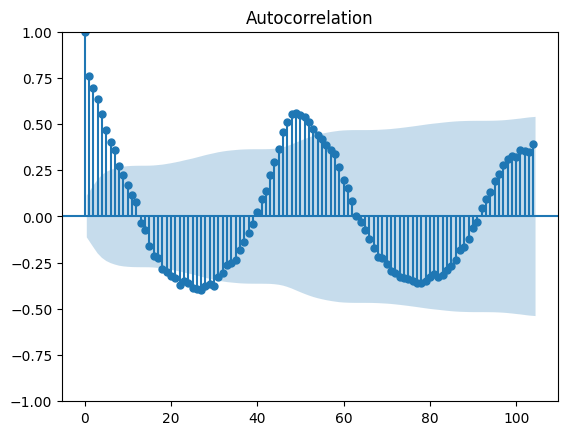

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(weekly_sales['R06'], lags=104)
plt.show()

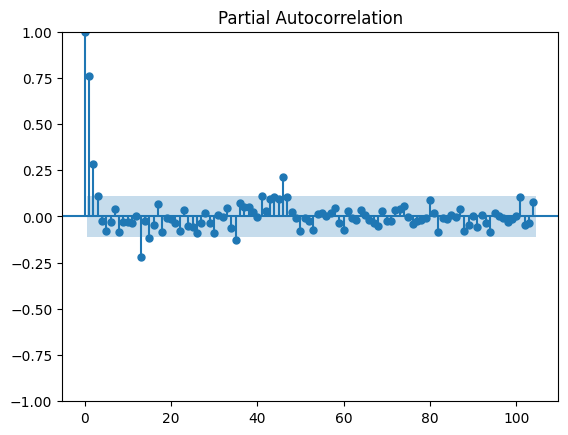

In [91]:
plot_pacf(weekly_sales['R06'], lags=104)
plt.show()

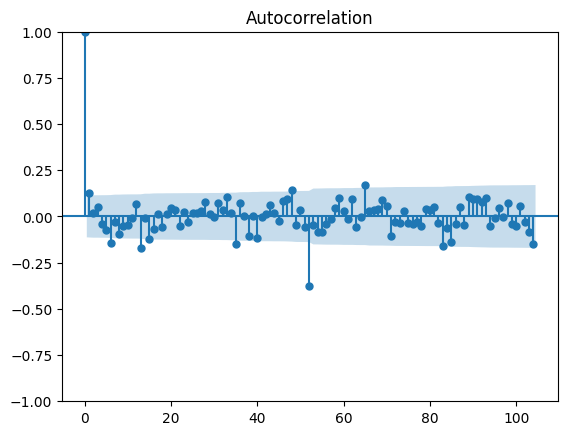

In [92]:
plot_acf(stl_result.resid, lags=104)
plt.show()

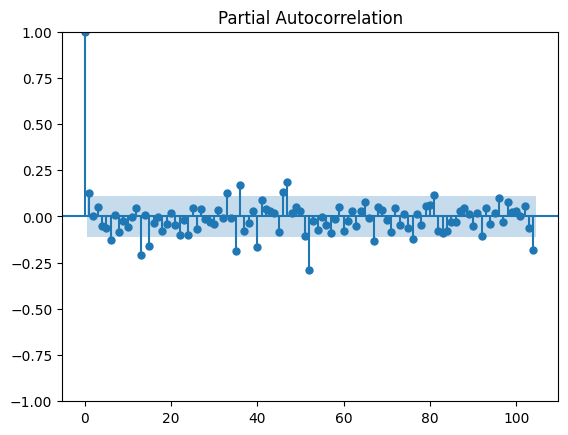

In [93]:
plot_pacf(stl_result.resid, lags=104)
plt.show()

## ADF Test

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

source: https://machinelearningmastery.com/time-series-data-stationary-python/

In [94]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test

adf_result, p_value, _, _, critical_values, _ = adfuller(R06_log)
print('ADF Statistic: %f' % adf_result)
print('p-value: %f' % p_value)
print('Critical Values:')
for key, value in critical_values.items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.598574
p-value: 0.000001
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


The ADF value is lower than the critical values (and p-value < 0.05) so the differenced time series is stationary.

## KPSS Test

This test uses the following null and alternative hypothesis:

**Null Hypothesis (H0)**: The time series is trend stationary.

**Alternate Hypothesis (H1)**: The time series is not trend stationary.

If the p-value of the test is less than some significance level (e.g. α = .05) then we reject the null hypothesis and conclude that the time series is not trend stationary (opposite of ADF test).

source: https://www.statology.org/kpss-test-in-python/



In [95]:
from statsmodels.tsa.stattools import kpss

In [96]:
p_value = 1
num_diffs = 0
R06_diff2 = R06_log.copy()
while p_value > 0.05:
    num_diffs += 1
    R06_diff2 = R06_diff2.diff(1)
    R06_diff2.dropna(inplace=True)
    kpss_result, p_value, _, critical_values = kpss(R06_diff2)
    
print("number of diffs: ", num_diffs)
print('KPSS Statistic: %f' % kpss_result)

number of diffs:  295
KPSS Statistic: 0.466112


C:\Users\Athos\AppData\Local\Temp\ipykernel_15888\2520914959.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result, p_value, _, critical_values = kpss(R06_diff2)
C:\Users\Athos\AppData\Local\Temp\ipykernel_15888\2520914959.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result, p_value, _, critical_values = kpss(R06_diff2)
C:\Users\Athos\AppData\Local\Temp\ipykernel_15888\2520914959.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result, p_value, _, critical_values = kpss(R06_diff2)
C:\Users\Athos\AppData\Local\Temp\ipykernel_15888\2520914959.py:8: InterpolationWarning: The test statistic is outs

---

## Data Splitting

In [97]:
# split time series into test and train
train = R06_log[:-52]
test = R06_log[-52:]
test_original = weekly_sales['R06'][-52:]
R06_original = weekly_sales['R06']

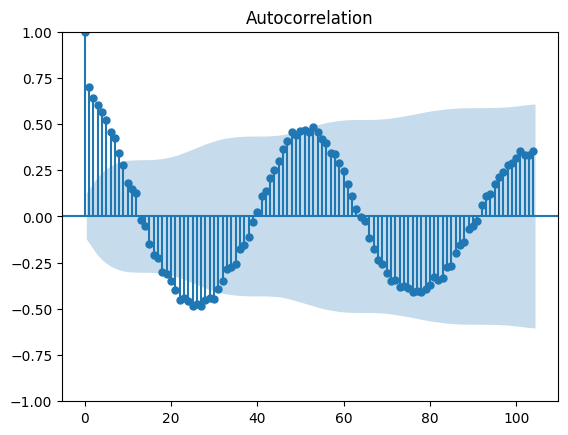

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(train, lags=104)
plt.show()

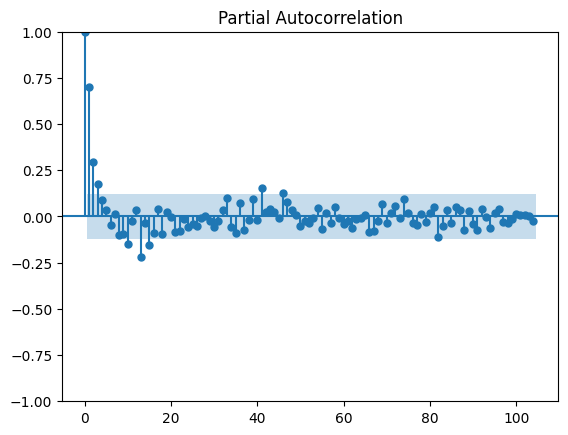

In [99]:
plot_pacf(train, lags=104)
plt.show()

## Modelling

### Using residuals from Seasonal-Trend Decomposition

In [100]:
# make STL decomposition of the train data
stl_train = STL(train, seasonal=53)  # Adjust the seasonal parameter based on the frequency of your data
stl_train_result = stl_train.fit()

In [101]:
# Modelling the seasonal component

from scipy.optimize import curve_fit

# Define a Fourier series function
def fourier_series(x, a0, a1, b1, a2, b2):
    return a0 + a1 * np.cos(2 * np.pi * x / period) + b1 * np.sin(2 * np.pi * x / period) + \
           a2 * np.cos(4 * np.pi * x / period) + b2 * np.sin(4 * np.pi * x / period)

# Using seasonality of 53 weeks
period = 53
x = np.arange(len(stl_train_result.seasonal))
y = stl_train_result.seasonal.values

# Fit the Fourier series
params, _ = curve_fit(fourier_series, x, y)

# Generate the approximation
seasonal_fit = fourier_series(x, *params)

# transform the seasonal_fit into a pandas series
seasonal_fit = pd.Series(seasonal_fit, index=stl_train_result.seasonal.index)

In [102]:
# Modelling the trend component

from sklearn.linear_model import LinearRegression

# Fit a linear model to the trend component
x = np.arange(len(stl_train_result.trend)).reshape(-1, 1)
y = stl_train_result.trend.values

trend_model = LinearRegression()
trend_model.fit(x, y)

# Generate the trend line
trend_fit = trend_model.predict(x)

# transform the trend_fit into a pandas series
trend_fit = pd.Series(trend_fit, index=stl_train_result.trend.index)


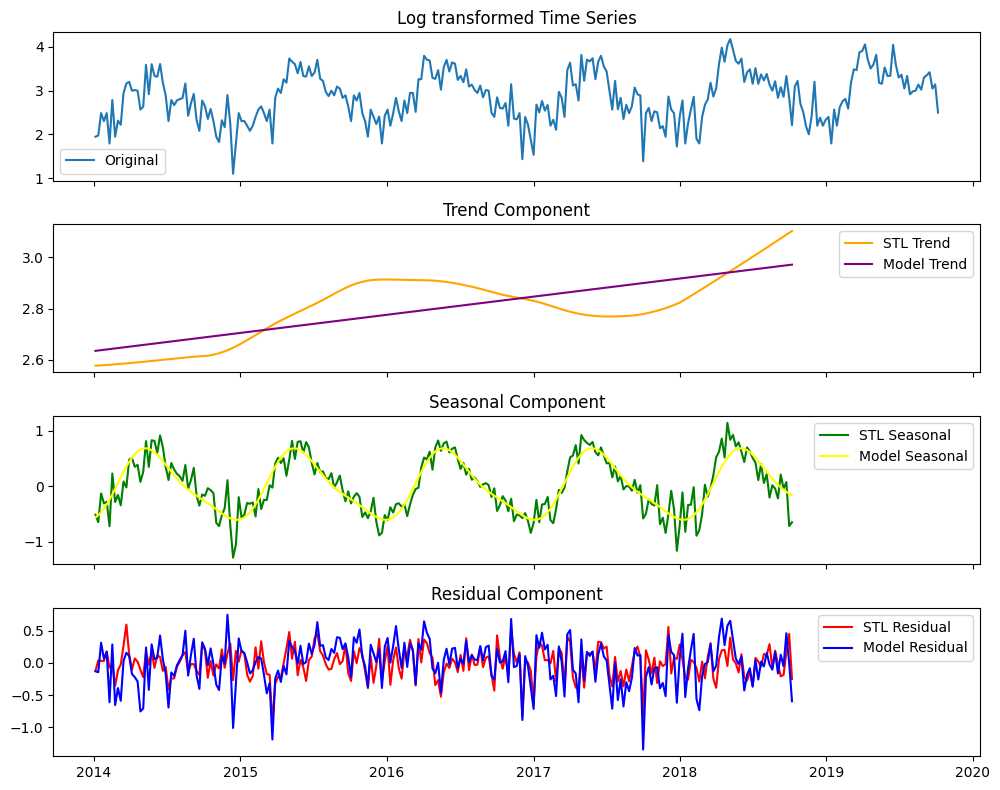

In [103]:
# get train data residuals by subtracting the trend and seasonal components from the test data using the models we just created
train_resid = train - trend_fit - seasonal_fit

# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original time series
axes[0].plot(R06_log, label='Original')
axes[0].set_title("Log transformed Time Series")
axes[0].legend()

# Trend component
axes[1].plot(stl_train_result.trend, label='STL Trend', color='orange')
axes[1].plot(trend_fit, label='Model Trend', color='purple')
axes[1].set_title("Trend Component")
axes[1].legend()

# Seasonal component
axes[2].plot(stl_train_result.seasonal, label='STL Seasonal', color='green')
axes[2].plot(seasonal_fit, label='Model Seasonal', color='yellow')
axes[2].set_title("Seasonal Component")
axes[2].legend()

# Residual component
axes[3].plot(stl_train_result.resid, label='STL Residual', color='red')
axes[3].plot(train_resid, label='Model Residual', color='blue')
axes[3].set_title("Residual Component")
axes[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [104]:
# ADF test on the residuals

adf_result, p_value, _, _, critical_values, _ = adfuller(train_resid)
print('ADF Statistic: %f' % adf_result)
print('p-value: %f' % p_value)
print('Critical Values:')
for key, value in critical_values.items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.533110
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


ADF Statistic < critical values (p-value < 0.05) -> stationary (unit root)

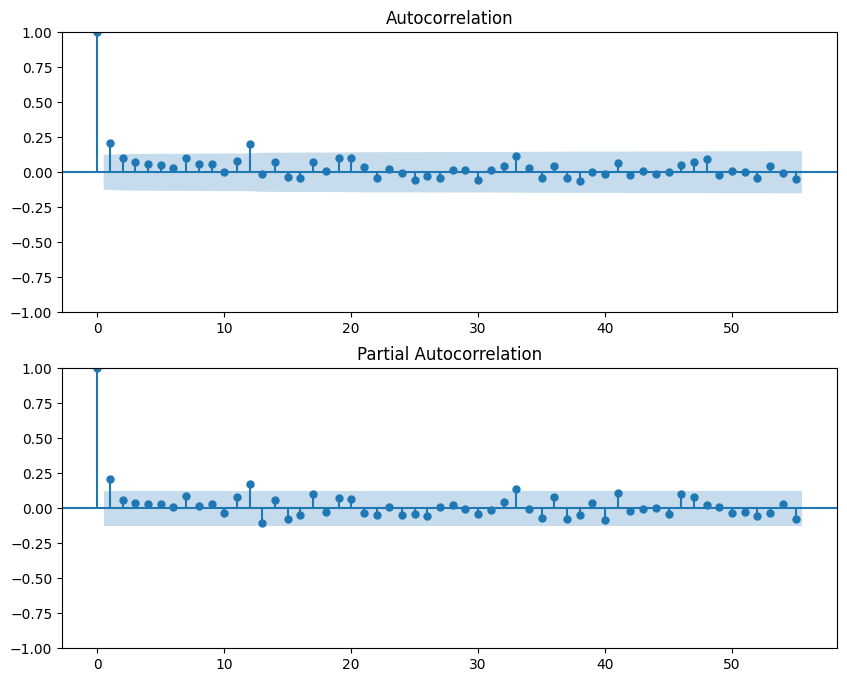

In [105]:
# Plot ACF and PACF of the residuals
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(train_resid, lags=55, ax=axes[0])
plot_pacf(train_resid, lags=55, ax=axes[1])
plt.show()

In [111]:

arima_components = (1,0,0)
decomposition_model = ARIMA(train_resid, order=arima_components)

fitted_decomposition_model = decomposition_model.fit()


In [112]:

fitted_decomposition_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  249
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -77.960
Date:                Sun, 05 Jan 2025   AIC                            161.919
Time:                        20:35:28   BIC                            172.472
Sample:                    01-05-2014   HQIC                           166.167
                         - 10-07-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.029     -0.129      0.898      -0.061       0.054
ar.L1          0.2140      0.068      3.168      0.002       0.082       0.346
sigma2         0.1095      0.009     12.830      0.000       0.093       0.126
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                35.29
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.71
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

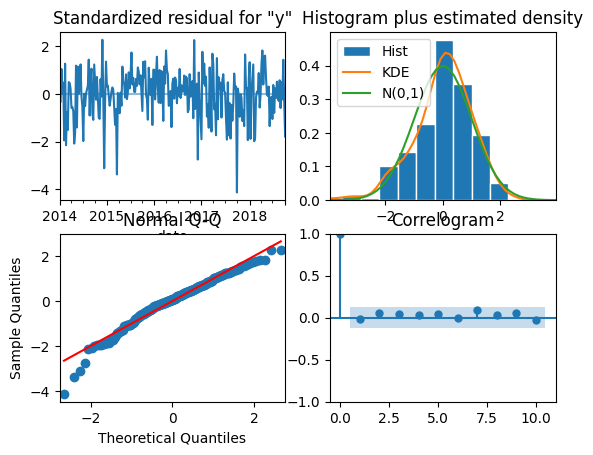

In [113]:
fitted_decomposition_model.plot_diagnostics()
plt.show()

### 52-step prediction

In [114]:
predictions_52_step = fitted_decomposition_model.forecast(len(test))
predictions_52_step = pd.Series(predictions_52_step, index=test.index)

pred_52_resid = predictions_52_step.copy()

# fit seasonal and trend components to the test data considering the starting point is the beginning of the test data/end of the train data
x_test = np.arange(len(stl_train_result.trend), len(stl_train_result.trend) + len(test))

pred_seasonal_fit = fourier_series(x_test, *params)
pred_trend_fit = trend_model.predict(x_test.reshape(-1, 1))

# transform seasonal and trend components into pandas series
pred_seasonal_fit = pd.Series(pred_seasonal_fit, index=test.index)
pred_trend_fit = pd.Series(pred_trend_fit, index=test.index)

# calculate the predictions in the original scale by adding the trend and seasonal components and then exponentiating
predictions_52_step = predictions_52_step + pred_trend_fit + pred_seasonal_fit
predictions_52_step_original = np.exp(predictions_52_step)

residuals_52_step_original = test_original - predictions_52_step

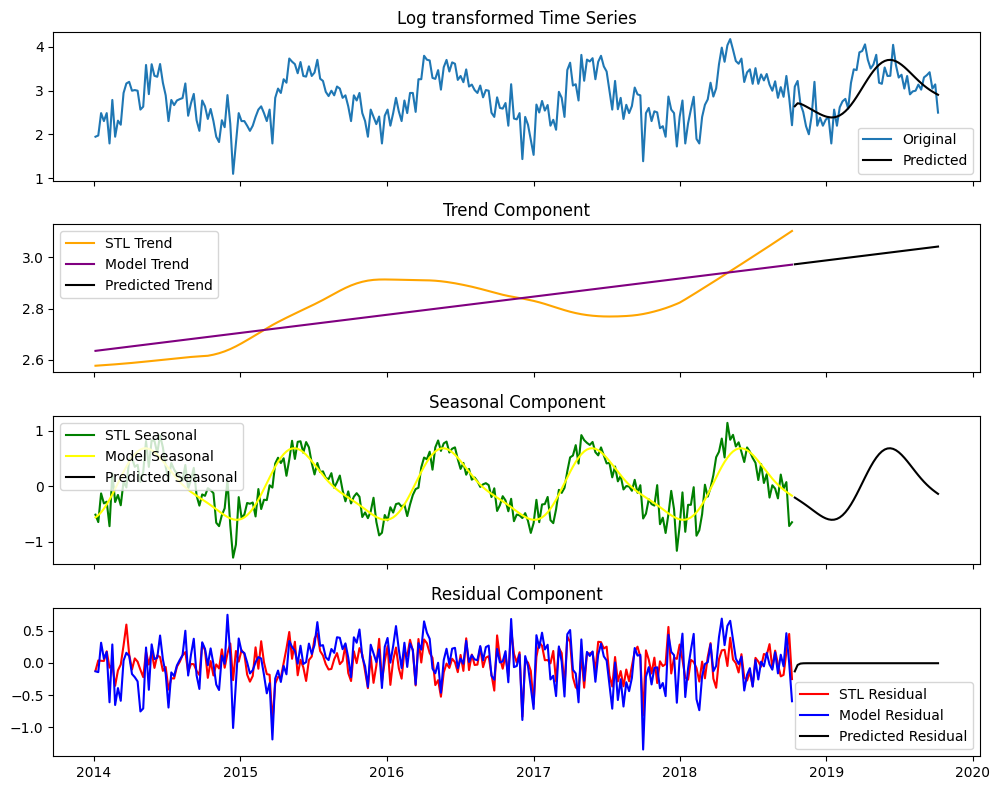

In [115]:
# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original time series
axes[0].plot(R06_log, label='Original')
axes[0].plot(predictions_52_step, label='Predicted', color='black')
axes[0].set_title("Log transformed Time Series")
axes[0].legend()

# Trend component
axes[1].plot(stl_train_result.trend, label='STL Trend', color='orange')
axes[1].plot(trend_fit, label='Model Trend', color='purple')
axes[1].plot(pred_trend_fit, label='Predicted Trend', color='black')
axes[1].set_title("Trend Component")
axes[1].legend()

# Seasonal component
axes[2].plot(stl_train_result.seasonal, label='STL Seasonal', color='green')
axes[2].plot(seasonal_fit, label='Model Seasonal', color='yellow')
axes[2].plot(pred_seasonal_fit, label='Predicted Seasonal', color='black')
axes[2].set_title("Seasonal Component")
# legend on  top left
axes[2].legend(loc='upper left')

# Residual component
axes[3].plot(stl_train_result.resid, label='STL Residual', color='red')
axes[3].plot(train_resid, label='Model Residual', color='blue')
axes[3].plot(pred_52_resid, label='Predicted Residual', color='black')
axes[3].set_title("Residual Component")
axes[3].legend()

# Adjust layout
plt.tight_layout()
plt.show()

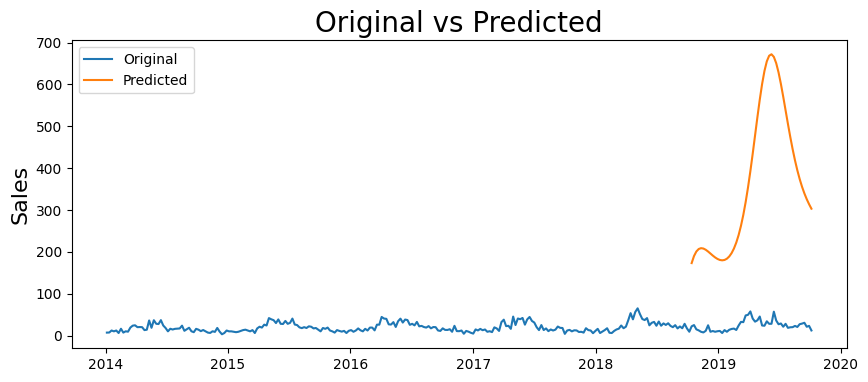

In [48]:
# plot original and predicted values
plt.figure(figsize=(10,4))
plt.plot(R06_original, label='Original')
plt.plot(predictions_52_step_original, label='Predicted')
plt.title('Original vs Predicted', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.legend()
plt.show()



### AR(3)

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_components = (3,0,0)
model = SARIMAX(train, order=arima_components)

fitted_model = model.fit()

In [50]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    R06   No. Observations:                  249
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -115.091
Date:                Sun, 05 Jan 2025   AIC                            238.182
Time:                        20:33:48   BIC                            252.252
Sample:                    01-05-2014   HQIC                           243.845
                         - 10-07-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4984      0.062      7.981      0.000       0.376       0.621
ar.L2          0.2669      0.064      4.142      0.000       0.141       0.393
ar.L3          0.2284      0.063      3.620      0.000       0.105       0.352
sigma2         0.1451      0.011     13.348      0.000       0.124       0.166
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                13.54
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.28
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

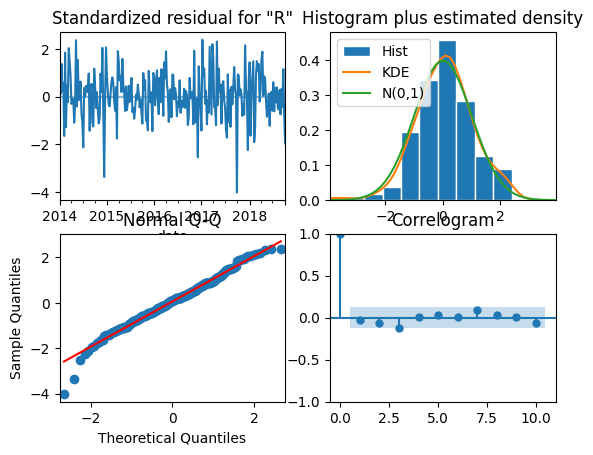

In [51]:
fitted_model.plot_diagnostics()
plt.show()

## 4.1 Forecasting 52 weeks (1 year) ahead

In [52]:
predictions_52_step = fitted_model.forecast(len(test))
predictions_52_step = pd.Series(predictions_52_step, index=test.index)

predictions_52_step_original = np.exp(predictions_52_step)

residuals_52_step_original = test_original - predictions_52_step

Text(0.5, 0, 'Year')

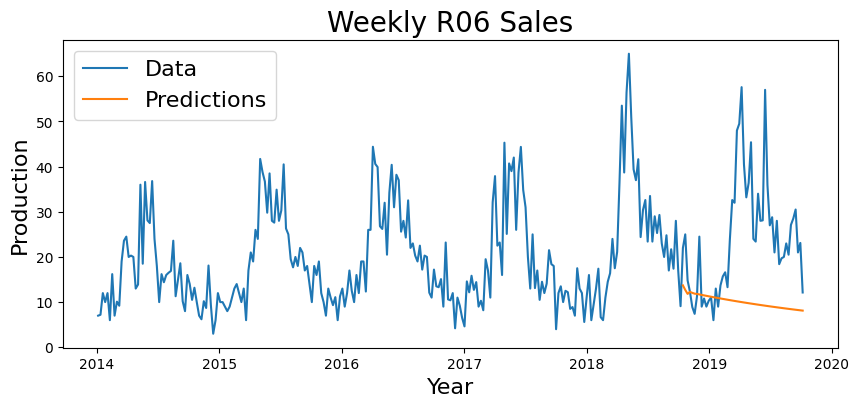

In [53]:
plt.figure(figsize=(10,4))

plt.plot(R06_original)
plt.plot(predictions_52_step_original)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Weekly R06 Sales', fontsize=20)
plt.ylabel('Production', fontsize=16)
plt.xlabel('Year', fontsize=16)

## 4.2 Forecasting 52 weeks 1-step ahead - Interaction

In [54]:

predictions_interaction = test.copy()
for train_end in test.index:
    train_data = R06_log[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=arima_components)
    model_fit = model.fit()

    # get last fitted value
    last_fitted_value = model_fit.fittedvalues.iloc[-1]
    
    # Store the prediction
    predictions_interaction[train_end] = last_fitted_value

predictions_interaction_original = np.exp(predictions_interaction)
residuals_interaction_original = test_original - predictions_interaction_original

Text(0.5, 0, 'Year')

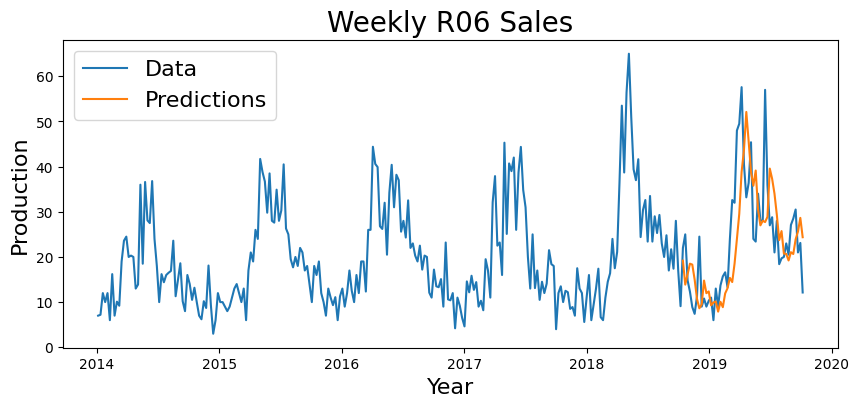

In [55]:
plt.figure(figsize=(10,4))

plt.plot(R06_original)
plt.plot(predictions_interaction_original)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Weekly R06 Sales', fontsize=20)
plt.ylabel('Production', fontsize=16)
plt.xlabel('Year', fontsize=16)

## 4.3 Forecasting 52 weeks 1-step ahead - Expanding Windows

In [56]:

predictions_exp_windows = test.copy()
for train_end in test.index:
    train_data = R06_log[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=arima_components)
    model_fit = model.fit()

    pred = model_fit.forecast()
    predictions_exp_windows[train_end] = float(pred.iloc[0])

predictions_exp_windows_original = np.exp(predictions_exp_windows)
residuals_exp_windows_original = test_original - predictions_exp_windows_original

Text(0.5, 0, 'Year')

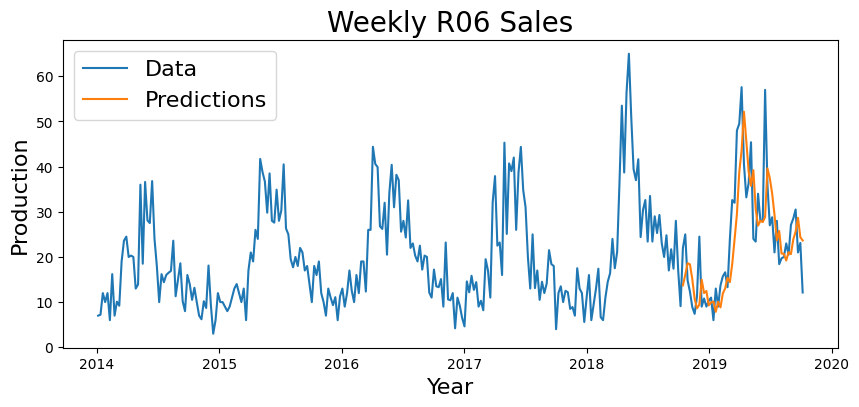

In [57]:
plt.figure(figsize=(10,4))

plt.plot(R06_original)
plt.plot(predictions_exp_windows_original)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Weekly R06 Sales', fontsize=20)
plt.ylabel('Production', fontsize=16)
plt.xlabel('Year', fontsize=16)

## 4.4 Forecasting 52 weeks 1-step ahead - Recursive Windows

In [58]:
predictions_rec_windows = test.copy()
train_starting_week = train.index[0]
for i, train_end in enumerate(test.index):    
    train_data = R06_log[train_starting_week+timedelta(days=7*i):train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=arima_components)
    model_fit = model.fit()

    pred = model_fit.forecast()
    predictions_rec_windows[train_end] = float(pred.iloc[0])

predictions_rec_windows_original = np.exp(predictions_rec_windows)
residuals_rec_windows_original = test_original - predictions_rec_windows_original

Text(0.5, 0, 'Year')

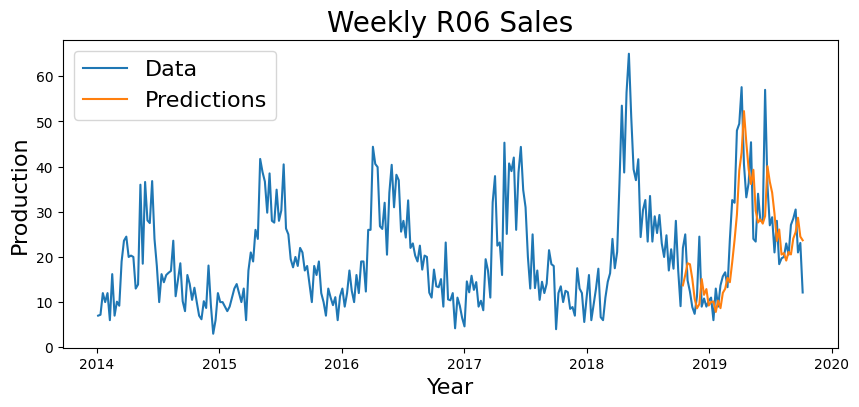

In [59]:
plt.figure(figsize=(10,4))

plt.plot(R06_original)
plt.plot(predictions_rec_windows_original)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Weekly R06 Sales', fontsize=20)
plt.ylabel('Production', fontsize=16)
plt.xlabel('Year', fontsize=16)

## 5. Assessing the quality of produced forecasts

In [60]:
predictions_52_step_original = np.exp(predictions_52_step)
predictions_interaction_original = np.exp(predictions_interaction)
predictions_exp_windows_original = np.exp(predictions_exp_windows)
predictions_rec_windows_original = np.exp(predictions_rec_windows)

Text(0.5, 0, 'Year')

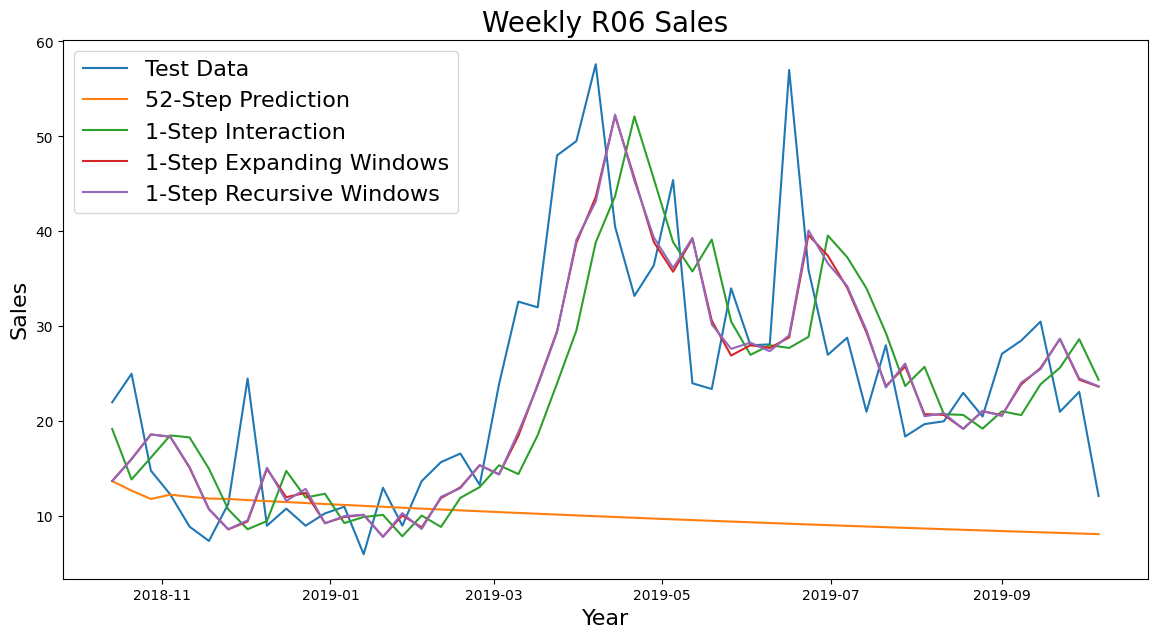

In [61]:
# plot of all predictions
plt.figure(figsize=(14,7))

plt.plot(test_original)
plt.plot(predictions_52_step_original)
plt.plot(predictions_interaction_original)
plt.plot(predictions_exp_windows_original)
plt.plot(predictions_rec_windows_original)

plt.legend(('Test Data','52-Step Prediction', '1-Step Interaction', '1-Step Expanding Windows', '1-Step Recursive Windows'), fontsize=16)

plt.title('Weekly R06 Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Year', fontsize=16)

Text(0.5, 0, 'Year')

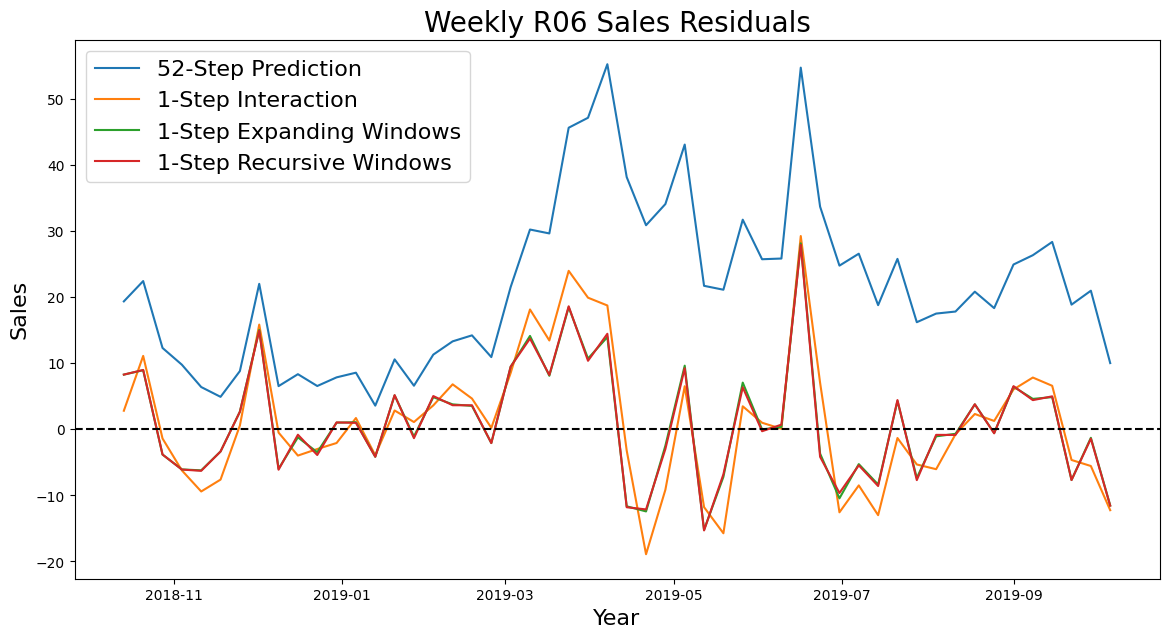

In [62]:
# plot the residuals from each method
plt.figure(figsize=(14,7))

plt.plot(residuals_52_step_original)
plt.plot(residuals_interaction_original)
plt.plot(residuals_exp_windows_original)
plt.plot(residuals_rec_windows_original)

plt.legend(('52-Step Prediction', '1-Step Interaction', '1-Step Expanding Windows', '1-Step Recursive Windows'), fontsize=16)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Weekly R06 Sales Residuals', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Year', fontsize=16)



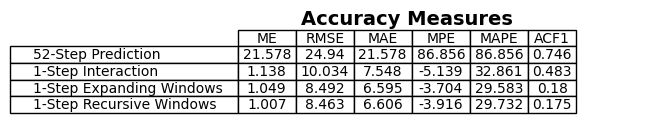

In [63]:

# Table with all the errors
errors = pd.DataFrame({
    # mean error
    'ME': [
        np.mean(residuals_52_step_original),
        np.mean(residuals_interaction_original),
        np.mean(residuals_exp_windows_original),
        np.mean(residuals_rec_windows_original)
    ],
    # root mean squared error
    'RMSE': [
        np.sqrt(np.mean(residuals_52_step_original**2)),
        np.sqrt(np.mean(residuals_interaction_original**2)),
        np.sqrt(np.mean(residuals_exp_windows_original**2)),
        np.sqrt(np.mean(residuals_rec_windows_original**2))
    ],
    # mean absolute error
    'MAE': [
        np.mean(abs(residuals_52_step_original)),
        np.mean(abs(residuals_interaction_original)),
        np.mean(abs(residuals_exp_windows_original)),
        np.mean(abs(residuals_rec_windows_original))
    ],
    # mean percentage error
    'MPE': [
        np.mean(residuals_52_step_original / test_original) * 100,
        np.mean(residuals_interaction_original / test_original) * 100,
        np.mean(residuals_exp_windows_original / test_original) * 100,
        np.mean(residuals_rec_windows_original / test_original) * 100
    ],
    # mean absolute percentage error
    'MAPE': [
        np.mean(abs(residuals_52_step_original / test_original)) * 100,
        np.mean(abs(residuals_interaction_original / test_original)) * 100,
        np.mean(abs(residuals_exp_windows_original / test_original)) * 100,
        np.mean(abs(residuals_rec_windows_original / test_original)) * 100
    ],
    # autocorrelation at lag 1
    'ACF1': [
        pd.Series(residuals_52_step_original).autocorr(lag=1),
        pd.Series(residuals_interaction_original).autocorr(lag=1),
        pd.Series(residuals_exp_windows_original).autocorr(lag=1),
        pd.Series(residuals_rec_windows_original).autocorr(lag=1)
    ]
}, index=['52-Step Prediction', '1-Step Interaction', '1-Step Expanding Windows', '1-Step Recursive Windows'])

# Plotting the table
fig, ax = plt.subplots(figsize=(6, 1))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=errors.round(3).values, 
                 colLabels=errors.columns, 
                 rowLabels=errors.index, 
                 loc='center', 
                 cellLoc='center', 
                 colLoc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(errors.columns))))

plt.title('Accuracy Measures', fontsize=14, weight='bold')
plt.show()
